In [1]:
import sys
import re
import os
from pathlib import Path
from collections import namedtuple

import numpy as np

### Taking data set from Seeval 2016 - task 5 subset 1 : http://alt.qcri.org/semeval2016/task5/

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import pickle
from collections import Counter, defaultdict
import re

pd.set_option('display.max_colwidth' , -1)

### English - Restaurant domain training data

In [3]:
import xml.etree.ElementTree as ET
english = ET.parse('../data/ABSA16_Restaurants_Train_SB1_v2.xml')
root = english.getroot()

In [4]:
labeled_reviews = []
for review in root.findall("Review"):
 

    if review.find("sentences"):
        
        for sentence in review.find("sentences").findall('sentence'): 
            if sentence.find('Opinions'):
                #print(sentence[0].text)
                entry= {} ;   aspects = [] ;  polarities = []
                for opinion in sentence.find('Opinions').findall('Opinion'):
                    aspects.append(opinion.get('category'))
                    polarities.append(opinion.get('polarity'))

        
    
                entry["text"] = sentence[0].text
                entry["aspects"] , entry['polarities']  =  aspects , polarities
                labeled_reviews.append(entry)
            
eng_multi_aspects = pd.DataFrame(labeled_reviews)
print("there are",len(labeled_reviews),"reviews in this training set")

there are 1708 reviews in this training set


In [5]:
eng_multi_aspects.head()

,aspects,polarities,text
0,[RESTAURANT#GENERAL],[negative],"Judging from previous posts this used to be a good place, but not any longer."
1,[SERVICE#GENERAL],[negative],"We, there were four of us, arrived at noon - the place was empty - and the staff acted like we were imposing on them and they were very rude."
2,[SERVICE#GENERAL],[negative],"They never brought us complimentary noodles, ignored repeated requests for sugar, and threw our dishes on the table."
3,"[FOOD#QUALITY, FOOD#STYLE_OPTIONS]","[negative, negative]",The food was lousy - too sweet or too salty and the portions tiny.
4,[SERVICE#GENERAL],[negative],"After all that, they complained to me about the small tip."


In [6]:
eng_multi_aspects.aspects.apply(pd.Series).merge(eng_multi_aspects , right_index = True , left_index = True)\
.drop(['aspects' , 'polarities'] ,axis = 1)\
.melt(id_vars = ['text']).drop(['variable'] , axis = 1).dropna().value.value_counts(normalize = True)


FOOD#QUALITY                0.338652
SERVICE#GENERAL             0.179099
RESTAURANT#GENERAL          0.168329
AMBIENCE#GENERAL            0.101715
FOOD#STYLE_OPTIONS          0.054647
RESTAURANT#MISCELLANEOUS    0.039091
FOOD#PRICES                 0.035899
RESTAURANT#PRICES           0.031911
DRINKS#QUALITY              0.018748
DRINKS#STYLE_OPTIONS        0.012764
LOCATION#GENERAL            0.011169
DRINKS#PRICES               0.007978
Name: value, dtype: float64

In [7]:
def extract_aspects(lst_aspects):
    res = []
    for x in lst_aspects:
        res.append(x.split('#')[0])
    return res
eng_multi_aspects['aspects2'] = eng_multi_aspects['aspects'].apply(lambda x: extract_aspects(x))
eng_multi_aspects['aspects2'] = eng_multi_aspects['aspects2'].apply(lambda x : list(set(x)))

In [8]:
eng_multi_aspects.aspects2.apply(pd.Series).merge(eng_multi_aspects , right_index = True , left_index = True)\
.drop(['aspects' , 'aspects2' , 'polarities'] , axis = 1).melt(id_vars = ['text']).drop(['variable'] , axis = 1).dropna().value.value_counts(normalize = True)

FOOD          0.365171
RESTAURANT    0.272069
SERVICE       0.202123
AMBIENCE      0.109021
DRINKS        0.038109
LOCATION      0.013507
Name: value, dtype: float64

Extract embedding of these english sentences

In [9]:
eng_multi_aspects[['text']].to_csv('../data/tatoeba/v1/english_resturant.txt' , header = None , index = None , mode = 'a')
#du_multi_aspects[['text']].to_csv('../data/tatoeba/v1/dutch_resturant.txt' , header = None , index = None , mode = 'a')

In [10]:
LASER_PATH = ".."
sys.path.append(LASER_PATH + '/source')
sys.path.append(LASER_PATH + '/source/lib')

DATA_PATH = Path("../data/tatoeba/v1/")
CACHE_PATH = Path("cache/")
CACHE_PATH.mkdir(exist_ok=True)
MODEL_PATH = Path("../models")

os.environ["LASER"] = LASER_PATH 

In [11]:
SPACE_NORMALIZER = re.compile("\s+")
Batch = namedtuple('Batch', 'srcs tokens lengths')

In [12]:
from indexing import IndexLoad, IndexTextOpen, IndexTextQuery, IndexSearchKNN, IndexCreate, IndexSearchMultiple
from embed import SentenceEncoder, EncodeLoad, EncodeFile
from text_processing import Token, BPEfastApply

#### Following steps from https://medium.com/the-artificial-impostor/multilingual-similarity-search-using-pretrained-bidirectional-lstm-encoder-e34fac5958b0 for tokenization , BPE Fast and Embedding extractions 

In [13]:
Token(
    str(DATA_PATH / "english_resturant.txt"),
    str(CACHE_PATH / "english_resturant.txt"),
    lang="eng",
    romanize=False,
    lower_case=True, gzip=False,
    verbose=True, over_write=False)

 - Tokenizer: english_resturant.txt exists already


In [14]:
bpe_codes = str(MODEL_PATH / "93langs.fcodes")
BPEfastApply(
    str(CACHE_PATH / "english_resturant.txt"),
    str(CACHE_PATH / "english_resturant.txt.bpe"),
    bpe_codes,
    verbose=True, over_write=False)

 - fast BPE: english_resturant.txt.bpe exists already


## Extract Setence Embeddings

In [15]:
encoder = SentenceEncoder(
    str(MODEL_PATH / "bilstm.93langs.2018-12-26.pt"),
    max_sentences=None,
    max_tokens=10000,
    cpu=False)

In [16]:
EncodeFile(
    encoder,
    str(CACHE_PATH / "english_resturant.txt.bpe"),
    str(CACHE_PATH / "english_resturant.txt.enc"),
    verbose=True, over_write=False)

 - Encoder: english_resturant.txt.enc exists already


In [17]:
data_en, index_en = IndexCreate(
    str(CACHE_PATH / "english_resturant.txt.enc"), 'FlatL2', verbose=True, save_index=False)
# data_du, index_du = IndexCreate(
#     str(CACHE_PATH / "dutch_resturant.txt.enc"), 'FlatL2', verbose=True, save_index=False)

 - embedding: cache/english_resturant.txt.enc 1708 examples of dim 1024
 - creating FAISS index


In [18]:
from sklearn.cluster import KMeans  
import pandas as pd
import matplotlib.pyplot as plt

#iris = load_iris()
data = data_en # pd.DataFrame(iris.data, columns=iris['feature_names'])

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    #data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
#plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
#plt.show()

Text(0, 0.5, 'SSE')

In [19]:
kmeans = KMeans(n_clusters=2 , random_state=42 , max_iter=1000 , n_init=20)  
kmeans.fit(data_en) 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=2, n_init=20, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [20]:
#eng_multi_aspects.drop(['polarities'] , axis = 1 , inplace=True)
eng_multi_aspects['cluster'] = kmeans.labels_
eng_multi_aspects.cluster.value_counts(normalize = True)

1    0.685597
0    0.314403
Name: cluster, dtype: float64

In [44]:
len(data_en[0]) , len(data_en[1])

(1024, 1024)

In [48]:
col = ['col_'+str(i) for i in range(1024)]

In [50]:
col[0:5]

['col_0', 'col_1', 'col_2', 'col_3', 'col_4']

In [56]:
encoded_features = pd.DataFrame(data_en ,columns = col)

In [57]:
eng_multi_aspects = pd.merge(eng_multi_aspects , encoded_features , left_index=True , right_index=True)

In [60]:
eng_single_aspects = eng_multi_aspects[eng_multi_aspects['aspects2'].apply(lambda x: len(x))==1]
eng_single_aspects['aspects2'] = eng_single_aspects['aspects2'].apply(lambda x: x[0])
eng_single_aspects['ct'] = 1

/home/FRACTAL/swati.tiwari/anaconda3/envs/fastai38/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/FRACTAL/swati.tiwari/anaconda3/envs/fastai38/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
eng_single_aspects.groupby(['aspects2' , 'cluster'])['ct'].sum()

aspects2    cluster
AMBIENCE    0          30 
            1          69 
DRINKS      0          19 
            1          27 
FOOD        0          149
            1          404
LOCATION    0          6  
            1          6  
RESTAURANT  0          239
            1          212
SERVICE     0          72 
            1          185
Name: ct, dtype: int64

### Create t - sNE plot

In [23]:
eng_single_aspects.head(2)

,aspects,polarities,text,aspects2,cluster,ct
0,[RESTAURANT#GENERAL],[negative],"Judging from previous posts this used to be a good place, but not any longer.",RESTAURANT,1,1
1,[SERVICE#GENERAL],[negative],"We, there were four of us, arrived at noon - the place was empty - and the staff acted like we were imposing on them and they were very rude.",SERVICE,1,1


In [25]:
eng_single_aspects.aspects2.value_counts(normalize = True)

FOOD          0.389986
RESTAURANT    0.318054
SERVICE       0.181241
AMBIENCE      0.069817
DRINKS        0.032440
LOCATION      0.008463
Name: aspects2, dtype: float64

In [61]:
#df_single_aspects = eng_single_aspects[eng_single_aspects['aspects2']]
#eng_single_aspects[eng_single_aspects['aspects2']=='DRINKS']
df_single_aspects = eng_single_aspects[(eng_single_aspects['aspects2']!='DRINKS') &( eng_single_aspects['aspects2']!='LOCATION')]

In [62]:
df_single_aspects.aspects2.value_counts()

FOOD          553
RESTAURANT    451
SERVICE       257
AMBIENCE      99 
Name: aspects2, dtype: int64

In [63]:
eng_multi_aspects.shape , eng_single_aspects.shape , df_single_aspects.shape

((1708, 1029), (1418, 1030), (1360, 1030))

In [67]:
df_single_aspects[col].shape

(1360, 1024)

In [68]:
import time
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [70]:
data_subset = df_single_aspects[col].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_single_aspects['pca-one'] = pca_result[:,0]
df_single_aspects['pca-two'] = pca_result[:,1] 
df_single_aspects['pca-three'] = pca_result[:,2]

/home/FRACTAL/swati.tiwari/anaconda3/envs/fastai38/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/FRACTAL/swati.tiwari/anaconda3/envs/fastai38/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/FRACTAL/swati.tiwari/anaconda3/envs/fastai38/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [71]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.09299583 0.04797413 0.02985822]


In [73]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(data_subset)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1360 samples in 0.086s...
[t-SNE] Computed neighbors for 1360 samples in 2.954s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1360
[t-SNE] Computed conditional probabilities for sample 1360 / 1360
[t-SNE] Mean sigma: 0.215467
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.070168
[t-SNE] KL divergence after 500 iterations: 1.682918
t-SNE done! Time elapsed: 8.289956331253052 seconds


/home/FRACTAL/swati.tiwari/anaconda3/envs/fastai38/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/FRACTAL/swati.tiwari/anaconda3/envs/fastai38/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


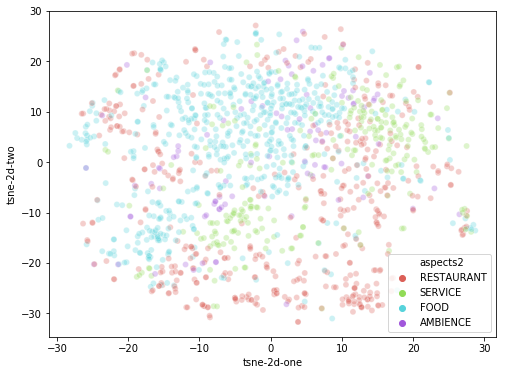

In [80]:
import seaborn as sns
df_single_aspects['tsne-2d-one'] = tsne_results[:,0]
df_single_aspects['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="aspects2",
    palette=sns.color_palette("hls", 4),
    data=df_single_aspects,
    legend="full",
    alpha=0.3
)


In [87]:
pca_250 = PCA(n_components=256)
pca_result_250 = pca_250.fit_transform(data_subset)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.8684667348861694


In [91]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=500)
tsne_pca_results = tsne.fit_transform(pca_result_250)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


t-SNE done! Time elapsed: 6.601095199584961 seconds


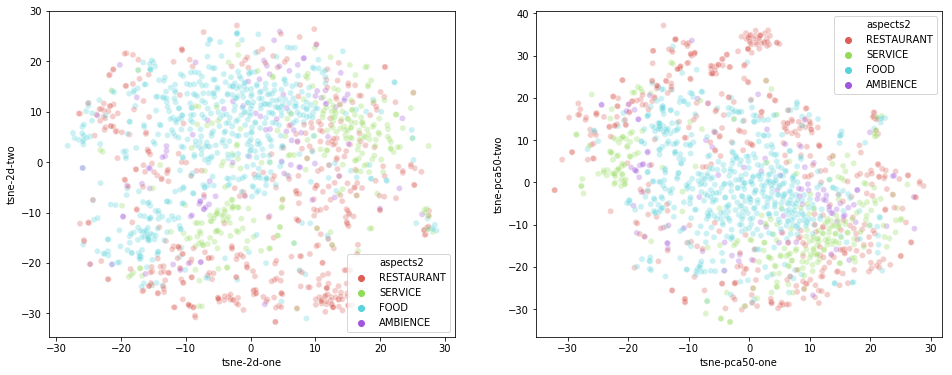

In [98]:
# df_single_aspects['tsne-pca50-one'] = tsne_pca_results[:,0]
# df_single_aspects['tsne-pca50-two'] = tsne_pca_results[:,1]
plt.figure(figsize=(16,6))
ax1 = plt.subplot(1, 2, 1)

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="aspects2",
    palette=sns.color_palette("hls", 4),
    data=df_single_aspects,
    legend="full",
    alpha=0.3,   ax=ax1)

ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x="tsne-pca250-one", y="tsne-pca250-two",
    hue="aspects2",
    palette=sns.color_palette("hls" , 4),
    data=df_single_aspects,
    legend="full",
    alpha=0.3 ,ax = ax2)

### Make an auto encoder 

In [182]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


In [183]:
EPOCH = 10
BATCH_SIZE = 64
LR = 0.005         # learning rate
# DOWNLOAD_MNIST = False
# N_TEST_IMG = 5

In [184]:
df_single_aspects[col].shape

(1360, 1024)

In [185]:
x_train = torch.from_numpy(np.array(df_single_aspects[col]))

In [186]:
print(x_train.shape)
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train)
train_dl = DataLoader(train_ds, batch_size=64 , shuffle=False)


torch.Size([1360, 1024])


In [209]:

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
#             nn.Tanh(),
#             nn.Linear(128, 64),   
        )
        self.decoder = nn.Sequential(
#             nn.Linear(64, 128),
#             nn.Tanh(),
            nn.Linear(128, 256),
            nn.Tanh(),
            nn.Linear(256, 512),
            nn.Tanh(),
            nn.Linear(512, 1024),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


autoencoder = AutoEncoder()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001 )
loss_func = nn.MSELoss()

In [210]:
for epoch in range(EPOCH):
    for step, (x) in enumerate(train_dl):
        #b_x = x.view(-1, 28*28)   # batch x, shape (batch, 28*28)
        #b_y = x.view(-1, 28*28)   # batch y, shape (batch, 28*28)
        b_x = x[0]
        b_y = x[0]
        encoded, decoded = autoencoder(b_x)

        loss = loss_func(decoded, b_y)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

        if step % 100 == 0:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy())

#             # plotting decoded image (second row)
#             _, decoded_data = autoencoder(view_data)
#             for i in range(N_TEST_IMG):
#                 a[1][i].clear()
#                 a[1][i].imshow(np.reshape(decoded_data.data.numpy()[i], (28, 28)), cmap='gray')
#                 a[1][i].set_xticks(()); a[1][i].set_yticks(())
#             plt.draw(); plt.pause(0.05)


Epoch:  0 | train loss: 0.2336
Epoch:  1 | train loss: 0.0009
Epoch:  2 | train loss: 0.0009
Epoch:  3 | train loss: 0.0009
Epoch:  4 | train loss: 0.0009
Epoch:  5 | train loss: 0.0009
Epoch:  6 | train loss: 0.0009
Epoch:  7 | train loss: 0.0009
Epoch:  8 | train loss: 0.0009
Epoch:  9 | train loss: 0.0009


In [211]:
view_data = train_ds[0:1360]
encoded_data, _ = autoencoder(view_data[0])
encoded_32 = encoded_data.data.cpu().numpy()

In [212]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=500)
tsne_pca_results = tsne.fit_transform(encoded_32)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 3.3070735931396484 seconds


In [213]:
df_single_aspects['tsne-encoded_32_one'] = tsne_pca_results[:,0]
df_single_aspects['tsne-encoded_32_two'] = tsne_pca_results[:,1]

/home/FRACTAL/swati.tiwari/anaconda3/envs/fastai38/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/FRACTAL/swati.tiwari/anaconda3/envs/fastai38/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



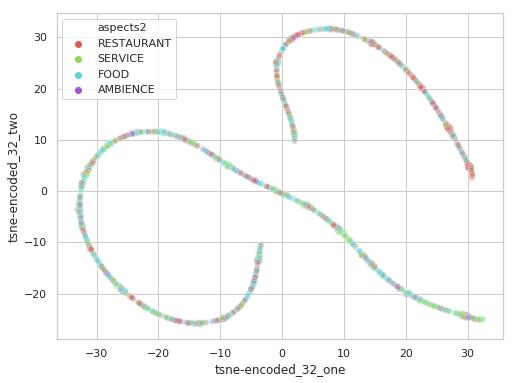

In [217]:
plt.figure(figsize=(8,6))
#ax1 = plt.subplot(1, 2, 1)

sns.scatterplot(
    x="tsne-encoded_32_one", y="tsne-encoded_32_two",
    hue="aspects2",
    palette=sns.color_palette("hls", 4),
    data=df_single_aspects,
    legend="full",
    alpha=0.3)


ValueError: Could not interpret input 'tsne-pca256-one'

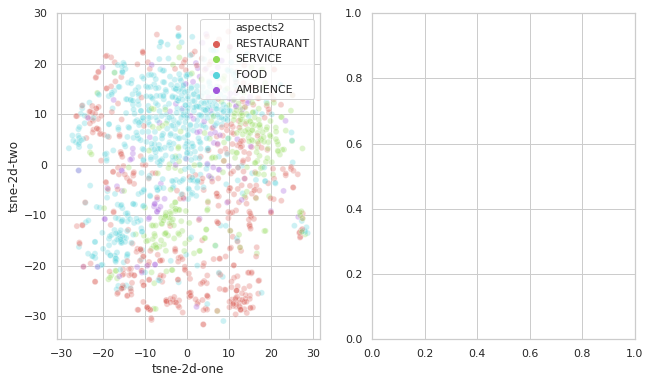

In [216]:
plt.figure(figsize=(16,6))
ax1 = plt.subplot(1, 3, 1)

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="aspects2",
    palette=sns.color_palette("hls", 4),
    data=df_single_aspects,
    legend="full",
    alpha=0.3,   ax=ax1)

ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(
    x="tsne-pca256-one", y="tsne-pca256-two",
    hue="aspects2",
    palette=sns.color_palette("hls" , 4),
    data=df_single_aspects,
    legend="full",
    alpha=0.3 ,ax = ax2)



ax2 = plt.subplot(1, 3, 3)
sns.scatterplot(
     x="tsne-encoded_128_one", y="tsne-encoded_128_two",
    hue="aspects2",
    palette=sns.color_palette("hls" , 4),
    data=df_single_aspects,
    legend="full",
    alpha=0.3 ,ax = ax3)

In [208]:
time_start = time.time()
tsne = TSNE(n_components=3, verbose=0, perplexity=40, n_iter=500)
tsne_pca_results = tsne.fit_transform(encoded_128)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
df_single_aspects['tsne-encoded_128_one'] = tsne_pca_results[:,0]
df_single_aspects['tsne-encoded_128_two'] = tsne_pca_results[:,1]
df_single_aspects['tsne-encoded_128_three'] = tsne_pca_results[:,2]


t-SNE done! Time elapsed: 22.765503406524658 seconds


/home/FRACTAL/swati.tiwari/anaconda3/envs/fastai38/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/FRACTAL/swati.tiwari/anaconda3/envs/fastai38/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/FRACTAL/swati.tiwari/anaconda3/envs/fastai38/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [154]:

# plt.figure(figsize=(8,6))
# #ax1 = plt.subplot(1, 2, 1)

# sns.scatterplot(
#     x="tsne-encoded_128_one", y="tsne-encoded_128_two", z = "tsne-encoded_128_three", 
#     hue="aspects2",
#     palette=sns.color_palette("hls", 4),
#     data=df_single_aspects,
#     legend="full",
#     alpha=0.3)


from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
sns.set(style="whitegrid")


In [157]:
df_single_aspects.aspects2.unique()

array(['RESTAURANT', 'SERVICE', 'FOOD', 'AMBIENCE'], dtype=object)

In [158]:
cover_type = {1:'RESTAURANT',2:'SERVICE',3:'FOOD',4 : 'AMBIENCE'}

In [173]:
pd.Categorical(df_single_aspects['aspects2']).codes

array([2, 3, 3, ..., 3, 3, 3], dtype=int8)

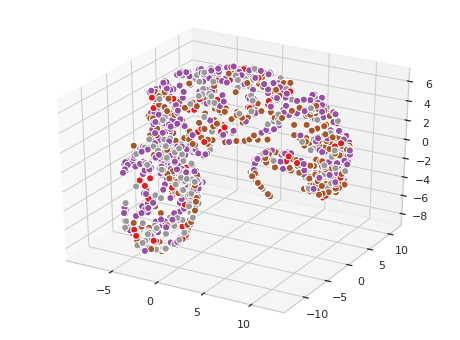

In [181]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111  , projection = '3d')  #)
ax.scatter(df_single_aspects["tsne-encoded_128_one"], df_single_aspects["tsne-encoded_128_two"],  df_single_aspects["tsne-encoded_128_three"]
           , c = pd.Categorical(df_single_aspects['aspects2']).codes  , cmap = "Set1" 
           ,s = 50 , alpha =1 , edgecolors ='w')

In [140]:
from plotly.offline import iplot , plot , download_plotlyjs , init_notebook_mode

In [142]:
init_notebook_mode(connected= True)

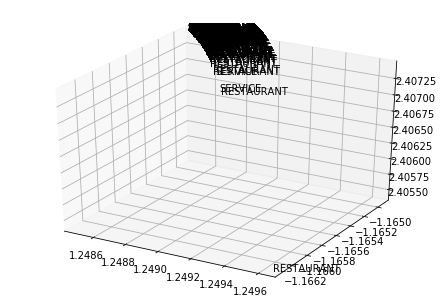

In [144]:
view_data = train_ds[0:1704]
encoded_data, _ = autoencoder(view_data[0])
fig = plt.figure(2); ax = Axes3D(fig)
X, Y, Z = encoded_data.data[:, 0].numpy(), encoded_data.data[:, 1].numpy(), encoded_data.data[:, 2].numpy()
values = eng_multi_aspects.aspects2.values   #train_data.train_labels[:200].numpy()
for x, y, z, s in zip(X, Y, Z, values):
    ax.text(x, y, z, s)
ax.set_xlim(X.min(), X.max()); ax.set_ylim(Y.min(), Y.max()); ax.set_zlim(Z.min(), Z.max())
plt.show()


#### We will search 3 nearest neighbour of 10  dutch sentences in all 1700 english sentences

In [20]:
_, matched_indices = index_en.search(data_du, 3)

In [21]:
du_list =  np.array(du_multi_aspects[['text']].head(10))
eng_list = np.array(eng_multi_aspects[['text']])
len(eng_list)

1708

In [22]:
top1_correct, top3_correct = 0, 0
for i, ztitle in enumerate(du_list):
    print(
        "Dutch:    ", ztitle, "\n",
        #"Correct:    ", translated_titles[i], "\n",
        "Predict(1): ", eng_list[matched_indices[i, 0]], "\n",
        "Predict(2): ", eng_list[matched_indices[i, 1]], "\n",
        "Predict(3): ", eng_list[matched_indices[i, 2]], "\n",
        sep=""
    )

Dutch:    ['Lange wachttijd.']
Predict(1): ['Great staff.']
Predict(2): ['Great survice']
Predict(3): ['Beautiful experience.']

Dutch:    ['Zelfde dessert, 2 dagen na mekaar.']
Predict(1): ['Dessert: pure disaster.']
Predict(2): ['The entree was bland and small, dessert was not inspired.']
Predict(3): ['We thought the dessert would be better, Wrong!']

Dutch:    ['Ontbijtbuffet was tip top in orde.']
Predict(1): ['fine dining restaurant quality.']
Predict(2): ['The buffet had a nice selection.']
Predict(3): ['Wine list selection is good and wine-by-the-glass was generously filled to the top.']

Dutch:    ['Niet goedkoop!']
Predict(1): ['Also very inexpensive.']
Predict(2): ['And amazingly cheap.']
Predict(3): ['Not worth it.']

Dutch:    ['Maar eens in het kasteelrestaurant aangekomen werd het een feest.']
Predict(1): ['After really enjoying ourselves at the bar we sat down at a table and had dinner.']
Predict(2): ['I attended a holiday dinner at the restaurant, and the food was major

##### Because dataset of semeval is not exact translation of each other , some of the above results are not good. 

### Creating multi label classification task using LASER sentence embedding. 
We can have 6 aspect categories , present for each review. We will train a simple 1 layer Neural Network model using 1024 dimensional sentence embedding as input and 6 categories as output.  
Train the model on 1700 English sentences and Validate on 1300 Dutch sentences . We are getting around 85 % accuracy and 57% f1 score(Macro) 

In [23]:
def extract_aspects(lst_aspects):
    res = []
    for x in lst_aspects:
        res.append(x.split('#')[0])
    return res

In [24]:
def extract_aspects(lst_aspects):
    res = []
    for x in lst_aspects:
        res.append(x.split('#')[0])
    return res
eng_multi_aspects['aspects2'] = eng_multi_aspects['aspects'].apply(lambda x: extract_aspects(x))
eng_multi_aspects['aspects2'] = eng_multi_aspects['aspects2'].apply(lambda x : list(set(x)))

Using only entity part out of entity#attribute tuple for simlicity

In [25]:
eng_multi_aspects.head(2)

,aspects,polarities,text,aspects2
0,[RESTAURANT#GENERAL],[negative],"Judging from previous posts this used to be a good place, but not any longer.",[RESTAURANT]
1,[SERVICE#GENERAL],[negative],"We, there were four of us, arrived at noon - the place was empty - and the staff acted like we were imposing on them and they were very rude.",[SERVICE]


In [26]:
eng_multi_aspects.aspects2.apply(pd.Series).merge(eng_multi_aspects , right_index = True , left_index = True)\
.drop(['aspects' , 'polarities' , 'aspects2'] ,axis = 1)\
.melt(id_vars = ['text']).drop(['variable'] , axis = 1).dropna().value.value_counts()


FOOD          757
RESTAURANT    564
SERVICE       419
AMBIENCE      226
DRINKS        79 
LOCATION      28 
Name: value, dtype: int64

In [27]:
du_multi_aspects['aspects2'] = du_multi_aspects['aspects'].apply(lambda x: extract_aspects(x))
du_multi_aspects['aspects2'] = du_multi_aspects['aspects2'].apply(lambda x : list(set(x)))

In [28]:
du_multi_aspects.head(2)

,aspects,polarities,text,aspects2
0,[SERVICE#GENERAL],[negative],Lange wachttijd.,[SERVICE]
1,[FOOD#STYLE_OPTIONS],[negative],"Zelfde dessert, 2 dagen na mekaar.",[FOOD]


In [29]:
du_multi_aspects.aspects2.apply(pd.Series).merge(du_multi_aspects , right_index = True , left_index = True)\
.drop(['aspects' , 'polarities' , 'aspects2'] ,axis = 1)\
.melt(id_vars = ['text']).drop(['variable'] , axis = 1).dropna().value.value_counts()

FOOD          547
SERVICE       420
RESTAURANT    353
AMBIENCE      178
DRINKS        92 
LOCATION      27 
Name: value, dtype: int64

In [30]:
eng_multi_aspects.drop(columns=['aspects' , 'polarities'] , inplace=True)
du_multi_aspects.drop(columns=['aspects' , 'polarities'] , inplace=True)

In [31]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb  = MultiLabelBinarizer()
y_eng = mlb.fit_transform(eng_multi_aspects.aspects2)
y_du  = mlb.fit_transform(du_multi_aspects.aspects2)

In [32]:
mlb.classes_

array(['AMBIENCE', 'DRINKS', 'FOOD', 'LOCATION', 'RESTAURANT', 'SERVICE'],
      dtype=object)

In [33]:
y_du[0:5]

array([[0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0]])

In [38]:
##One layer neural network with ReLU activation
n_in, n_h, n_out, batch_size = 1024,  500 , 6, 64

model = nn.Sequential(nn.Linear(n_in, n_h),
                     nn.ReLU(),
                     nn.Linear(n_h, n_out))

In [35]:
import torch 
import torch
import torch.nn as nn

x_train,y_train,x_valid,y_valid = map(torch.FloatTensor, (data_en,y_eng, data_du,y_du))
n,c = x_train.shape
y_train = y_train.type(torch.FloatTensor)
y_valid = y_valid.type(torch.FloatTensor)


In [36]:
print(y_train.shape , y_valid.shape)
print(x_train.shape , x_valid.shape)

torch.Size([1708, 6]) torch.Size([1317, 6])
torch.Size([1708, 1024]) torch.Size([1317, 1024])


In [39]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size , shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid )
valid_dl = DataLoader(valid_ds , batch_size= batch_size )

In [40]:
class WrappedDataLoader():
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
        
    def __len__(self): return len(self.dl)
    
    def __iter__(self):
        batches = iter(self.dl)
        for b in batches: yield(self.func(*b))

In [41]:
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
def preprocess(x,y): return x.to(dev),y.to(dev)

train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)


In [42]:
from torch import optim
optimizer = optim.Adam(model.parameters() , lr = 1e-2)
loss_func = nn.BCEWithLogitsLoss()

In [43]:
model = model.to(dev)
loss_func = loss_func.to(dev)

def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    acc = torch.sum(rounded_preds == y).float() 
    return acc

In [44]:
def train_model(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0    
    model.train()
    ct = 0
    for x, y in iterator:
        optimizer.zero_grad()
        #text, text_lengths =x
        predictions = model(x)
        loss = criterion(predictions, y)
        acc = binary_accuracy(predictions, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        ct = ct + x.shape[0]   
    return epoch_loss / len(iterator), epoch_acc / (ct*6)

In [45]:
def validate_model(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0 
    ct = 0
    model.eval()
    with torch.no_grad():
        for x ,y  in iterator:

            predictions = model(x)#.squeeze(1)
            loss = criterion(predictions,y)
            acc = binary_accuracy(predictions, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            ct = ct + x.shape[0]
        
    return epoch_loss / len(iterator), epoch_acc / (ct*6)

In [46]:
epochs = 5

best_valid_loss = float('inf')
best_epoch = 0
        
for epoch in range(1, epochs + 1):
    train_loss , train_acc = train_model(model, train_dl, optimizer, loss_func)
    valid_loss , valid_acc = validate_model(model, valid_dl, loss_func)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_epoch = epoch
        #print(f'Best validation loss!! {best_valid_loss}')
        #torch.save(model.state_dict(), 'aspect_category.pt')

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 02
	Train Loss: 0.408 | Train Acc: 81.40%
	 Val. Loss: 0.358 |  Val. Acc: 85.71%
Epoch: 03
	Train Loss: 0.264 | Train Acc: 89.51%
	 Val. Loss: 0.291 |  Val. Acc: 87.55%
Epoch: 04
	Train Loss: 0.199 | Train Acc: 92.21%
	 Val. Loss: 0.265 |  Val. Acc: 88.88%
Epoch: 05
	Train Loss: 0.157 | Train Acc: 94.02%
	 Val. Loss: 0.266 |  Val. Acc: 88.98%
Epoch: 06
	Train Loss: 0.131 | Train Acc: 94.76%
	 Val. Loss: 0.272 |  Val. Acc: 88.88%


In [47]:
test_preds = []
text_data = []
true_label = []

model.eval()
with torch.no_grad():
    for x ,y  in valid_dl:
        predictions = model(x)#.squeeze(1)
        rounded_preds = torch.round(torch.sigmoid(predictions))  #torch.round
        preds = rounded_preds.data.cpu().numpy()
        test_preds.append(preds)
        true_label.append(y.data.cpu().numpy())

In [48]:
aspects = mlb.classes_.tolist()

In [49]:
"""
Merging prediction value with original test data and observe the metrics on overall level
"""
dutch_pred = pd.DataFrame(np.vstack(test_preds) ,index=du_multi_aspects.index , columns= [a+'_pred' for a in aspects])
dutch_pred = pd.merge(du_multi_aspects, dutch_pred , left_index=True ,right_index = True)

from sklearn.metrics import f1_score , confusion_matrix , accuracy_score , precision_score , recall_score , roc_auc_score

In [50]:
print("F1 score",f1_score(y_du , dutch_pred[dutch_pred.columns[-6:]].as_matrix() , average='macro' ))
print("Accuracy score" , np.mean(y_du == dutch_pred[dutch_pred.columns[-6:]].as_matrix()))

F1 score 0.5785150146523276
Accuracy score 0.8887623386484435


/home/FRACTAL/swati.tiwari/anaconda3/envs/fastai38/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/home/FRACTAL/swati.tiwari/anaconda3/envs/fastai38/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/FRACTAL/swati.tiwari/anaconda3/envs/fastai38/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [52]:
dutch_pred.tail()

,text,aspects2,AMBIENCE_pred,DRINKS_pred,FOOD_pred,LOCATION_pred,RESTAURANT_pred,SERVICE_pred
1312,Niet goedkoop maar zeker zijn geld waard.,[RESTAURANT],0.0,0.0,1.0,0.0,1.0,0.0
1313,Zeer goede wijnen.,[DRINKS],0.0,1.0,0.0,0.0,0.0,0.0
1314,"wij zijn hier een paar keer per jaar, en steeds slaagt men erin te verrassen.",[RESTAURANT],0.0,0.0,0.0,0.0,1.0,0.0
1315,In de eerste plaats de creatieve gerechten en steeds terugkerend de top service.,"[FOOD, SERVICE]",0.0,0.0,0.0,0.0,0.0,1.0
1316,Een vaste waarde op topniveau,[RESTAURANT],0.0,0.0,0.0,0.0,1.0,0.0
